In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

In [0]:
from keras.models import Model
from keras.layers import *
from keras.activations import *

In [0]:
def get_gru_last_step(lstm_sequences):
    return Lambda(lambda sequence: sequence[:, -1, :])(lstm_sequences)

def classification_block(input_layer, dropout_rate=0.2):
    model = Dense(256, activation='linear',
                  kernel_initializer='he_normal')(input_layer)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    model = Dense(256, activation='linear',
                  kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    return Dense(6, activation='sigmoid', kernel_initializer='glorot_normal')(model)

In [0]:
max_words = 30000
max_words_length = 400
embedding_dimension = 300

gru_options = {
    'units': 64,
    'dropout': 0.2,
    'return_sequences': True
}

In [11]:
input_layer = Input(shape=(max_words_length,))

pretrained_embedding_layer = Embedding(
    max_words,
    output_dim=embedding_dimension,
    input_length=max_words_length,
    weights=[np.load('fast_text_embeddings.npy')],
    trainable=False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    max_words,
    output_dim=embedding_dimension,
    input_length=max_words_length,
    weights=[np.load('custom_fast_text_embeddings.npy')],
    trainable=False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

averaged_embedding_layer = Average()(
    [pretrained_embedding_layer, custom_embedding_layer])
averaged_embedding_layer = SpatialDropout1D(0.2)(averaged_embedding_layer)

gru = Bidirectional(
  CuDNNGRU(
    units=gru_options['units'],
    return_sequences=gru_options['return_sequences']
  )
)(averaged_embedding_layer)
gru = Dropout(gru_options['dropout'])(gru)

pooled_features = concatenate([
    GlobalMaxPooling1D()(gru),
    GlobalAveragePooling1D()(gru),
    get_gru_last_step(gru)
])

pooled_features = Dropout(0.2)(pooled_features)

output_layer = classification_block(pooled_features, dropout_rate=0.2)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='binary_crossentropy', 
            optimizer='Adam',
            metrics=['accuracy'])          

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [12]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21248/102124 [=====>........................] - ETA: 4:34 - loss: 0.1144 - acc: 0.9615

 60192/102124 [================>.............] - ETA: 2:18 - loss: 0.0824 - acc: 0.9718

 98176/102124 [===========================>..] - ETA: 12s - loss: 0.0733 - acc: 0.9746

102124/102124 [==============================] - 364s 4ms/step - loss: 0.0726 - acc: 0.9748 - val_loss: 0.0470 - val_acc: 0.9828
Epoch 2/32
 12544/102124 [==>...........................] - ETA: 4:53 - loss: 0.0549 - acc: 0.9799

 84064/102124 [=======================>......] - ETA: 58s - loss: 0.0526 - acc: 0.9804

102124/102124 [==============================] - 362s 4ms/step - loss: 0.0524 - acc: 0.9805 - val_loss: 0.0443 - val_acc: 0.9834
roc-auc: 0.9873 - roc-auc_val: 0.9845                                                                                                    
Epoch 3/32
  4416/102124 [>.............................] - ETA: 5:18 - loss: 0.0465 - acc: 0.9832

 69216/102124 [===================>..........] - ETA: 1:47 - loss: 0.0489 - acc: 0.9815

102124/102124 [==============================] - 362s 4ms/step - loss: 0.0485 - acc: 0.9816 - val_loss: 0.0426 - val_acc: 0.9838
Epoch 4/32
  1440/102124 [..............................] - ETA: 5:29 - loss: 0.0526 - acc: 0.9791

 46720/102124 [============>.................] - ETA: 3:00 - loss: 0.0471 - acc: 0.9819

 89312/102124 [=========================>....] - ETA: 41s - loss: 0.0459 - acc: 0.9824

102124/102124 [==============================] - 362s 4ms/step - loss: 0.0461 - acc: 0.9823 - val_loss: 0.0453 - val_acc: 0.9829
roc-auc: 0.99 - roc-auc_val: 0.9871                                                                                                    
Epoch 5/32
  5760/102124 [>.............................] - ETA: 5:16 - loss: 0.0469 - acc: 0.9818

 77024/102124 [=====================>........] - ETA: 1:21 - loss: 0.0444 - acc: 0.9828

102124/102124 [==============================] - 362s 4ms/step - loss: 0.0445 - acc: 0.9827 - val_loss: 0.0425 - val_acc: 0.9840
Epoch 6/32
  4416/102124 [>.............................] - ETA: 5:19 - loss: 0.0437 - acc: 0.9837

 68160/102124 [===================>..........] - ETA: 1:50 - loss: 0.0432 - acc: 0.9832

102124/102124 [==============================] - 362s 4ms/step - loss: 0.0434 - acc: 0.9832 - val_loss: 0.0427 - val_acc: 0.9836
roc-auc: 0.9919 - roc-auc_val: 0.9886                                                                                                    
Epoch 7/32
   608/102124 [..............................] - ETA: 5:35 - loss: 0.0471 - acc: 0.9811

 48576/102124 [=============>................] - ETA: 2:54 - loss: 0.0422 - acc: 0.9835

 94560/102124 [==========================>...] - ETA: 24s - loss: 0.0421 - acc: 0.9836

102124/102124 [==============================] - 362s 4ms/step - loss: 0.0420 - acc: 0.9837 - val_loss: 0.0420 - val_acc: 0.9842
Epoch 8/32
 11136/102124 [==>...........................] - ETA: 4:56 - loss: 0.0395 - acc: 0.9846

 56256/102124 [===============>..............] - ETA: 2:29 - loss: 0.0408 - acc: 0.9841

102112/102124 [============================>.] - ETA: 0s - loss: 0.0412 - acc: 0.9839

102124/102124 [==============================] - 362s 4ms/step - loss: 0.0412 - acc: 0.9839 - val_loss: 0.0413 - val_acc: 0.9847
roc-auc: 0.9924 - roc-auc_val: 0.9884                                                                                                    
Epoch 9/32
  8704/102124 [=>............................] - ETA: 5:04 - loss: 0.0412 - acc: 0.9838

 51744/102124 [==============>...............] - ETA: 2:44 - loss: 0.0406 - acc: 0.9841

102112/102124 [============================>.] - ETA: 0s - loss: 0.0407 - acc: 0.9840

102124/102124 [==============================] - 362s 4ms/step - loss: 0.0407 - acc: 0.9840 - val_loss: 0.0410 - val_acc: 0.9846
Epoch 10/32
 10144/102124 [=>............................] - ETA: 5:00 - loss: 0.0387 - acc: 0.9850

 99520/102124 [============================>.] - ETA: 8s - loss: 0.0398 - acc: 0.9844

102124/102124 [==============================] - 363s 4ms/step - loss: 0.0399 - acc: 0.9844 - val_loss: 0.0418 - val_acc: 0.9845
roc-auc: 0.9932 - roc-auc_val: 0.989                                                                                                    
Epoch 11/32
  8128/102124 [=>............................] - ETA: 5:06 - loss: 0.0392 - acc: 0.9843

 53056/102124 [==============>...............] - ETA: 2:39 - loss: 0.0386 - acc: 0.9847

 96000/102124 [===========================>..] - ETA: 19s - loss: 0.0397 - acc: 0.9843

102124/102124 [==============================] - 362s 4ms/step - loss: 0.0396 - acc: 0.9843 - val_loss: 0.0446 - val_acc: 0.9840

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00017677669529803097.
Epoch 12/32
  8576/102124 [=>............................] - ETA: 5:04 - loss: 0.0406 - acc: 0.9849

 45152/102124 [============>.................] - ETA: 3:05 - loss: 0.0393 - acc: 0.9845

 87360/102124 [========================>.....] - ETA: 48s - loss: 0.0390 - acc: 0.9846

102124/102124 [==============================] - 361s 4ms/step - loss: 0.0387 - acc: 0.9847 - val_loss: 0.0459 - val_acc: 0.9839
roc-auc: 0.9935 - roc-auc_val: 0.9883                                                                                                    
Epoch 13/32
  5248/102124 [>.............................] - ETA: 5:16 - loss: 0.0404 - acc: 0.9836

 52992/102124 [==============>...............] - ETA: 2:40 - loss: 0.0379 - acc: 0.9852

 97824/102124 [===========================>..] - ETA: 14s - loss: 0.0383 - acc: 0.9849

102124/102124 [==============================] - 362s 4ms/step - loss: 0.0383 - acc: 0.9849 - val_loss: 0.0434 - val_acc: 0.9845
Epoch 14/32
 12288/102124 [==>...........................] - ETA: 4:54 - loss: 0.0395 - acc: 0.9841

 58048/102124 [================>.............] - ETA: 2:23 - loss: 0.0378 - acc: 0.9850

102112/102124 [============================>.] - ETA: 0s - loss: 0.0378 - acc: 0.9849

102124/102124 [==============================] - 362s 4ms/step - loss: 0.0378 - acc: 0.9849 - val_loss: 0.0435 - val_acc: 0.9844
roc-auc: 0.9938 - roc-auc_val: 0.9884                                                                                                    
Epoch 15/32
  8640/102124 [=>............................] - ETA: 5:05 - loss: 0.0369 - acc: 0.9854

 47200/102124 [============>.................] - ETA: 2:59 - loss: 0.0373 - acc: 0.9853

 99424/102124 [============================>.] - ETA: 8s - loss: 0.0374 - acc: 0.9852

102124/102124 [==============================] - 362s 4ms/step - loss: 0.0373 - acc: 0.9852 - val_loss: 0.0438 - val_acc: 0.9845
Epoch 16/32
 12928/102124 [==>...........................] - ETA: 4:50 - loss: 0.0374 - acc: 0.9847

 50400/102124 [=============>................] - ETA: 2:48 - loss: 0.0373 - acc: 0.9852

 87200/102124 [========================>.....] - ETA: 48s - loss: 0.0372 - acc: 0.9852

102124/102124 [==============================] - 362s 4ms/step - loss: 0.0372 - acc: 0.9852 - val_loss: 0.0439 - val_acc: 0.9844
roc-auc: 0.9943 - roc-auc_val: 0.9888                                                                                                    
Epoch 17/32
  5184/102124 [>.............................] - ETA: 5:16 - loss: 0.0359 - acc: 0.9861

 51264/102124 [==============>...............] - ETA: 2:45 - loss: 0.0369 - acc: 0.9854

 92704/102124 [==========================>...] - ETA: 30s - loss: 0.0368 - acc: 0.9854

102124/102124 [==============================] - 362s 4ms/step - loss: 0.0367 - acc: 0.9855 - val_loss: 0.0436 - val_acc: 0.9844
Epoch 18/32
 10432/102124 [==>...........................] - ETA: 4:59 - loss: 0.0344 - acc: 0.9863

 58336/102124 [================>.............] - ETA: 2:22 - loss: 0.0361 - acc: 0.9854

100128/102124 [============================>.] - ETA: 6s - loss: 0.0363 - acc: 0.9853

102124/102124 [==============================] - 362s 4ms/step - loss: 0.0363 - acc: 0.9854 - val_loss: 0.0423 - val_acc: 0.9846
roc-auc: 0.9944 - roc-auc_val: 0.9887                                                                                                    
Epoch 19/32
  8224/102124 [=>............................] - ETA: 5:05 - loss: 0.0353 - acc: 0.9862

 47616/102124 [============>.................] - ETA: 2:57 - loss: 0.0358 - acc: 0.9856

 86624/102124 [========================>.....] - ETA: 50s - loss: 0.0360 - acc: 0.9856

102124/102124 [==============================] - 362s 4ms/step - loss: 0.0360 - acc: 0.9855 - val_loss: 0.0414 - val_acc: 0.9847


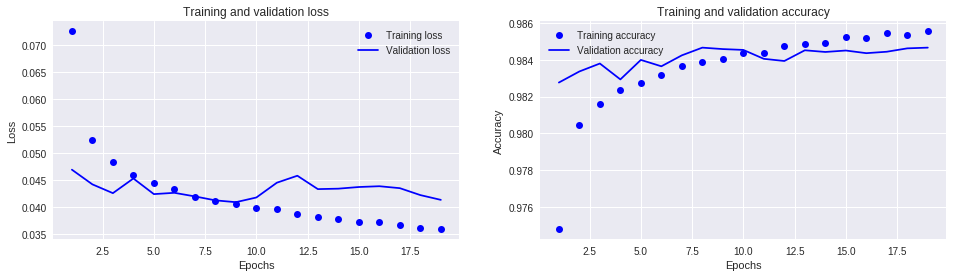

In [13]:
plot_history(history)

In [14]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 39s 1ms/step
([0.04005879932652955, 0.9851062589036845], 0.9903181292040192)
